In [22]:
# Standard library imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

# Project imports
import sys
sys.path.append('..')
from src.config import (
    SEED, DATA_DIR, FIGURES_DIR, TARGET_COL, CLAIM_NB_COL, EXPOSURE_COL,
    CATEGORICAL_FEATURES, NUMERICAL_FEATURES, ALL_FEATURES,
    ORDINAL_FEATURES, NOMINAL_FEATURES, AREA_ORDER
)
from src.utils import evaluate_regression, print_metrics

# Sklearn imports
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import KFold

# Set random seed for reproducibility
np.random.seed(SEED)
plt.style.use('seaborn-v0_8-darkgrid')
print(f"Imports done. Seed: {SEED}")

Imports done. Seed: 42


In [23]:
# Load training and test data
df_train = pd.read_csv(DATA_DIR / 'claims_train.csv')
df_test = pd.read_csv(DATA_DIR / 'claims_test.csv')

# Data cleaning: remove observations with Exposure > 1 (invalid data)
df_train = df_train[df_train[EXPOSURE_COL] <= 1].copy()

# Create target variable: ClaimFrequency = ClaimNb / Exposure
df_train[TARGET_COL] = df_train[CLAIM_NB_COL] / df_train[EXPOSURE_COL]
df_test[TARGET_COL] = df_test[CLAIM_NB_COL] / df_test[EXPOSURE_COL]

# Prepare features (X) and target (y)
X_train_full_raw = df_train[ALL_FEATURES]
y_train_full = df_train[TARGET_COL].values
X_test_raw = df_test[ALL_FEATURES]
y_test = df_test[TARGET_COL].values

# Setup 5-fold cross-validation (test set held out for final evaluation only)
K_FOLDS = 5
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=SEED)

print(f"Train: {len(X_train_full_raw):,} samples, Test: {len(X_test_raw):,} samples (held out)")
print(f"Target - Mean: {y_train_full.mean():.4f}, Std: {y_train_full.std():.4f}, Max: {y_train_full.max():.1f}")

Train: 541,416 samples, Test: 135,603 samples (held out)
Target - Mean: 0.2616, Std: 4.4322, Max: 732.0


In [24]:
# Preprocessing function: fits encoders on train fold, transforms both train and val
# This prevents data leakage by ensuring validation data doesn't influence encoding
def preprocess_data(X_train_df, X_val_df):
    # Numerical features: no transformation needed for tree-based models
    X_train_num = X_train_df[NUMERICAL_FEATURES].values
    X_val_num = X_val_df[NUMERICAL_FEATURES].values
    
    # Ordinal encoding for Area (preserves order: A < B < C < D < E < F)
    ordinal_enc = OrdinalEncoder(categories=[AREA_ORDER])
    X_train_ord = ordinal_enc.fit_transform(X_train_df[ORDINAL_FEATURES])
    X_val_ord = ordinal_enc.transform(X_val_df[ORDINAL_FEATURES])
    
    # One-hot encoding for nominal features (VehBrand, VehGas, Region)
    onehot_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
    X_train_nom = onehot_enc.fit_transform(X_train_df[NOMINAL_FEATURES])
    X_val_nom = onehot_enc.transform(X_val_df[NOMINAL_FEATURES])
    
    # Combine all features
    return np.hstack([X_train_num, X_train_ord, X_train_nom]), np.hstack([X_val_num, X_val_ord, X_val_nom])

# Cross-validation function for Random Forest
def cv_random_forest(X_df, y, n_estimators, max_depth, min_samples_split, min_samples_leaf,
                     max_features=None, max_samples=None):
    cv_scores = {'R2': [], 'RMSE': [], 'MAE': [], 'MSE': []}
    cv_times = []
    last_model = None
    
    for train_idx, val_idx in kfold.split(X_df):
        # Split data for this fold
        X_tr_raw, X_vl_raw = X_df.iloc[train_idx], X_df.iloc[val_idx]
        y_tr, y_vl = y[train_idx], y[val_idx]
        
        # Preprocess within fold (prevents data leakage)
        X_tr, X_vl = preprocess_data(X_tr_raw, X_vl_raw)
        
        # Create and train model
        model = RandomForestRegressor(
            n_estimators=n_estimators, max_depth=max_depth,
            min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
            max_features=max_features, max_samples=max_samples,
            random_state=SEED, n_jobs=-1, verbose=0)
        
        start = time.time()
        model.fit(X_tr, y_tr)
        cv_times.append(time.time() - start)
        
        # Evaluate on validation fold
        metrics = evaluate_regression(y_vl, model.predict(X_vl))
        for k in cv_scores: 
            cv_scores[k].append(metrics[k])
        last_model = model
    
    # Return mean and std for each metric
    return {k: (np.mean(v), np.std(v)) for k, v in cv_scores.items()}, np.mean(cv_times), last_model

# Calculate number of features after encoding
temp_ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
temp_ohe.fit(X_train_full_raw[NOMINAL_FEATURES])
n_features = len(NUMERICAL_FEATURES) + len(ORDINAL_FEATURES) + len(temp_ohe.get_feature_names_out())
print(f"Features after encoding: {n_features}")

Features after encoding: 38


In [25]:
# Baseline Random Forest with default hyperparameters
print("BASELINE (default params)")
cv_base, time_base, last_rf = cv_random_forest(
    X_train_full_raw, y_train_full, n_estimators=100, max_depth=None,
    min_samples_split=2, min_samples_leaf=1)

print(f"  MAE:  {cv_base['MAE'][0]:.4f} ± {cv_base['MAE'][1]:.4f}")
print(f"  RMSE: {cv_base['RMSE'][0]:.4f} ± {cv_base['RMSE'][1]:.4f}")
print(f"  MSE:  {cv_base['MSE'][0]:.4f} ± {cv_base['MSE'][1]:.4f}")
print(f"  Time/fold: {time_base:.1f}s")

BASELINE (default params)
  MAE:  0.5267 ± 0.0159
  RMSE: 4.9760 ± 0.4297
  MSE:  24.9457 ± 4.2117
  Time/fold: 42.3s


Top 10 features:
       Feature  Importance
       Density    0.310743
       DrivAge    0.257806
    BonusMalus    0.126121
        VehAge    0.088569
      VehPower    0.065483
          Area    0.038020
VehGas_Regular    0.027998
   VehBrand_B2    0.010430
  VehBrand_B12    0.009986
    Region_R82    0.009969


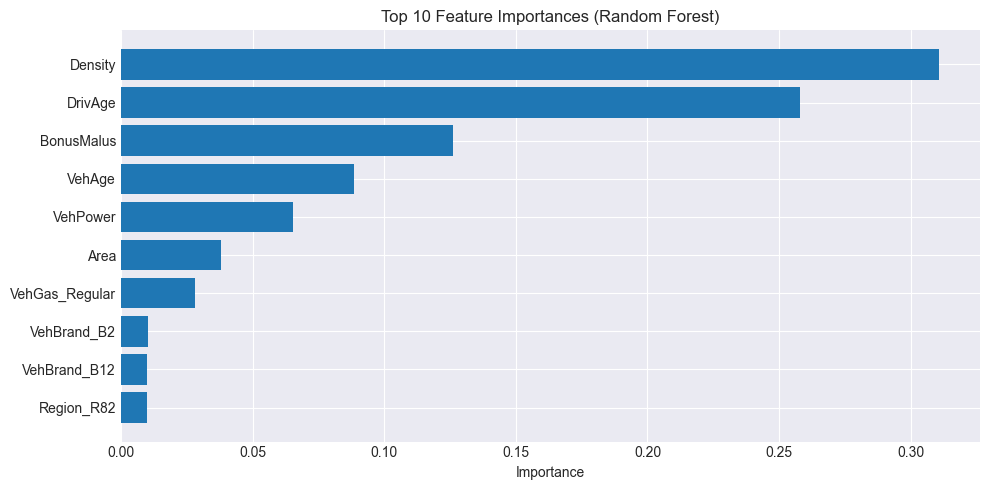

In [26]:
# Feature importance analysis (from last CV fold model)
# Get feature names in the same order as preprocessing
feat_names = list(NUMERICAL_FEATURES) + list(ORDINAL_FEATURES) + temp_ohe.get_feature_names_out().tolist()

# Create importance DataFrame
imp_df = pd.DataFrame({'Feature': feat_names, 'Importance': last_rf.feature_importances_})
imp_df = imp_df.sort_values('Importance', ascending=False)

print("Top 10 features:")
print(imp_df.head(10).to_string(index=False))

# Plot feature importance
plt.figure(figsize=(10, 5))
plt.barh(imp_df['Feature'].head(10)[::-1], imp_df['Importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.title('Top 10 Feature Importances (Random Forest)')
plt.tight_layout()
plt.savefig(FIGURES_DIR / 'rf_feature_importance.png', dpi=150)
plt.show()

In [27]:
# Hyperparameter configurations to test
# Strategy: progressively add regularization to reduce overfitting
# Baseline overfits due to extreme outliers in target (max=732)
# Using MAE for selection as it's more robust to outliers than other metrics.
configs = [
    # 1. Baseline: default params (for comparison)
    {'name': 'Baseline', 'n_estimators': 100, 'max_depth': None, 
     'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': None, 'max_samples': None},
    # 2. Increase min_samples_leaf to reduce overfitting
    {'name': 'min_leaf=10', 'n_estimators': 100, 'max_depth': None, 
     'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_samples': None},
    # 3. Add max_depth constraint
    {'name': 'depth=15,leaf=10', 'n_estimators': 100, 'max_depth': 15, 
     'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': None, 'max_samples': None},
    # 4. Add min_samples_split constraint
    {'name': 'depth=15,split=50,leaf=10', 'n_estimators': 100, 'max_depth': 15, 
     'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': None, 'max_samples': None},
    # 5. Add feature subsampling
    {'name': 'depth=15,leaf=10,feat=0.5', 'n_estimators': 100, 'max_depth': 15, 
     'min_samples_split': 2, 'min_samples_leaf': 10, 'max_features': 0.5, 'max_samples': None},
    # 6. Full regularization: all constraints
    {'name': 'Full regularization', 'n_estimators': 100, 'max_depth': 15, 
     'min_samples_split': 50, 'min_samples_leaf': 10, 'max_features': 0.3, 'max_samples': 0.6},
]
print(f"Testing {len(configs)} configurations")

Testing 6 configurations


In [28]:
# Run 5-fold CV for each configuration (selecting by MAE)
results = []
for i, cfg in enumerate(configs, 1):
    print(f"[{i}/{len(configs)}] {cfg['name']}... ", end="", flush=True)
    cv_res, avg_time, _ = cv_random_forest(
        X_train_full_raw, y_train_full,
        n_estimators=cfg['n_estimators'], max_depth=cfg['max_depth'],
        min_samples_split=cfg['min_samples_split'], min_samples_leaf=cfg['min_samples_leaf'],
        max_features=cfg['max_features'], max_samples=cfg['max_samples'])
    
    # Store all metrics
    results.append({
        'Config': cfg['name'],
        'max_depth': cfg['max_depth'] if cfg['max_depth'] else 'None',
        'min_samples_split': cfg['min_samples_split'],
        'min_samples_leaf': cfg['min_samples_leaf'],
        'max_features': cfg['max_features'] if cfg['max_features'] else 'None',
        'max_samples': cfg['max_samples'] if cfg['max_samples'] else 'None',
        'MAE_mean': cv_res['MAE'][0], 'MAE_std': cv_res['MAE'][1],
        'RMSE_mean': cv_res['RMSE'][0], 'RMSE_std': cv_res['RMSE'][1],
        'MSE_mean': cv_res['MSE'][0], 'MSE_std': cv_res['MSE'][1],
        'Time_s': avg_time * K_FOLDS})
    print(f"MAE={cv_res['MAE'][0]:.4f}±{cv_res['MAE'][1]:.4f}, RMSE={cv_res['RMSE'][0]:.4f}")
print("Done.")

[1/6] Baseline... MAE=0.5267±0.0159, RMSE=4.9760
[2/6] min_leaf=10... MAE=0.4822±0.0104, RMSE=4.4148
[3/6] depth=15,leaf=10... MAE=0.4799±0.0102, RMSE=4.4161
[4/6] depth=15,split=50,leaf=10... MAE=0.4781±0.0097, RMSE=4.4090
[5/6] depth=15,leaf=10,feat=0.5... MAE=0.4767±0.0090, RMSE=4.3966
[6/6] Full regularization... MAE=0.4783±0.0083, RMSE=4.3927
Done.


In [29]:
# Display CV results sorted by MAE (lower is better)
results_df = pd.DataFrame(results).sort_values('MAE_mean', ascending=True)
print(results_df[['Config', 'MAE_mean', 'MAE_std', 'RMSE_mean', 'RMSE_std', 'MSE_mean', 'Time_s']].to_string(index=False))

# Select best configuration based on CV MAE
best = results_df.iloc[0]
print(f"\nBest config: {best['Config']}")
print(f"  MAE:  {best['MAE_mean']:.4f} ± {best['MAE_std']:.4f}")
print(f"  RMSE: {best['RMSE_mean']:.4f} ± {best['RMSE_std']:.4f}")
print(f"  MSE:  {best['MSE_mean']:.4f} ± {best['MSE_std']:.4f}")

                   Config  MAE_mean  MAE_std  RMSE_mean  RMSE_std  MSE_mean     Time_s
depth=15,leaf=10,feat=0.5  0.476729 0.008994   4.396576  0.412910 19.500379 100.655959
depth=15,split=50,leaf=10  0.478124 0.009725   4.409038  0.411755 19.609159 199.510401
      Full regularization  0.478338 0.008286   4.392710  0.414439 19.467661  44.318860
         depth=15,leaf=10  0.479851 0.010212   4.416109  0.411478 19.671332 211.790369
              min_leaf=10  0.482212 0.010391   4.414820  0.410505 19.659146 287.822554
                 Baseline  0.526667 0.015948   4.976042  0.429740 24.945676 296.115183

Best config: depth=15,leaf=10,feat=0.5
  MAE:  0.4767 ± 0.0090
  RMSE: 4.3966 ± 0.4129
  MSE:  19.5004 ± 3.5612


In [30]:
# Train final model on full training set with best hyperparameters
print(f"Training final model: {best['Config']}")

# Fit encoders on full training data (for final model only)
ord_enc = OrdinalEncoder(categories=[AREA_ORDER])
X_train_ord = ord_enc.fit_transform(X_train_full_raw[ORDINAL_FEATURES])
X_test_ord = ord_enc.transform(X_test_raw[ORDINAL_FEATURES])

ohe_enc = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')
X_train_nom = ohe_enc.fit_transform(X_train_full_raw[NOMINAL_FEATURES])
X_test_nom = ohe_enc.transform(X_test_raw[NOMINAL_FEATURES])

# Combine all features
X_train_full = np.hstack([X_train_full_raw[NUMERICAL_FEATURES].values, X_train_ord, X_train_nom])
X_test = np.hstack([X_test_raw[NUMERICAL_FEATURES].values, X_test_ord, X_test_nom])

# Extract best hyperparameters
max_d = None if best['max_depth'] == 'None' else int(best['max_depth'])
max_f = None if best['max_features'] == 'None' else best['max_features']
max_s = None if best['max_samples'] == 'None' else best['max_samples']

# Create and train final model
rf_final = RandomForestRegressor(
    n_estimators=100, max_depth=max_d,
    min_samples_split=int(best['min_samples_split']),
    min_samples_leaf=int(best['min_samples_leaf']),
    max_features=max_f, max_samples=max_s,
    random_state=SEED, n_jobs=-1)

start = time.time()
rf_final.fit(X_train_full, y_train_full)
print(f"Training time: {time.time()-start:.1f}s")

Training final model: depth=15,leaf=10,feat=0.5
Training time: 27.6s


In [31]:
# Evaluate final model on held-out test set
y_train_pred = rf_final.predict(X_train_full)
y_test_pred = rf_final.predict(X_test)

# Calculate metrics for train and test sets
train_metrics = evaluate_regression(y_train_full, y_train_pred)
test_metrics = evaluate_regression(y_test, y_test_pred)

print("FINAL MODEL EVALUATION")
print("\nTrain set:")
print_metrics(train_metrics, "Train")
print("\nTest set:")
print_metrics(test_metrics, "Test")

# Check generalization
r2_gap = train_metrics['R2'] - test_metrics['R2']
rmse_gap = test_metrics['RMSE'] - train_metrics['RMSE']
print(f"\nGeneralization:")
print(f"  R² gap (train-test):   {r2_gap:.6f}")
print(f"  RMSE gap (test-train): {rmse_gap:.4f}")

FINAL MODEL EVALUATION

Train set:

Train Performance:
  MSE       : 17.756742
  RMSE      : 4.213875
  MAE       : 0.459859
  R2        : 0.096075

Test set:

Test Performance:
  MSE       : 26.781227
  RMSE      : 5.175058
  MAE       : 0.488576
  R2        : 0.011293

Generalization:
  R² gap (train-test):   0.084782
  RMSE gap (test-train): 0.9612
